In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import os
from sklearn.model_selection import train_test_split
from PIL import Image

from keras.models import Sequential
from skimage.util import random_noise
from skimage import img_as_ubyte
from keras.preprocessing.image import ImageDataGenerator
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import copy
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
import tensorflow as tf
from keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout


In [50]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/kaggle/input/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
102539,00027326_000.png,No Finding,0,27326,10,M,PA,2302,2141,0.143000,0.143000,NaN,/kaggle/input/data/images_011/images/00027326_...
107065,00028880_000.png,No Finding,0,28880,37,M,PA,2021,2021,0.194311,0.194311,NaN,/kaggle/input/data/images_012/images/00028880_...
42501,00010936_019.png,Pneumothorax,19,10936,38,F,PA,2992,2989,0.143000,0.143000,NaN,/kaggle/input/data/images_005/images/00010936_...


In [53]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
column_headers = ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia']
for header in column_headers:
    all_xray_df[header] = None
    
column_headers = all_xray_df['Finding Labels'].str.get_dummies(sep='|').columns

# Add columns for each unique column header and set initial values to 0
for header in column_headers:
    all_xray_df[header] = 0

# Set the respective column entry to 1 when the 'Finding Labels' string matches the column header
for index, row in all_xray_df.iterrows():
    findings = row['Finding Labels'].split('|')
    for finding in findings:
        if finding in column_headers:
            all_xray_df.at[index, finding] = 1
    
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Fibrosis,Hernia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,1,0,0,1,0,0,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0


In [55]:
all_xray_df['pneumonia_class'] = 0
all_xray_df.loc[all_xray_df['Finding Labels'].str.contains('Pneumonia'), 'pneumonia_class'] = 1

In [56]:
all_xray_df['path']

0         /kaggle/input/data/images_001/images/00000001_...
1         /kaggle/input/data/images_001/images/00000001_...
2         /kaggle/input/data/images_001/images/00000001_...
3         /kaggle/input/data/images_001/images/00000002_...
4         /kaggle/input/data/images_001/images/00000003_...
                                ...                        
112115    /kaggle/input/data/images_012/images/00030801_...
112116    /kaggle/input/data/images_012/images/00030802_...
112117    /kaggle/input/data/images_012/images/00030803_...
112118    /kaggle/input/data/images_012/images/00030804_...
112119    /kaggle/input/data/images_012/images/00030805_...
Name: path, Length: 112120, dtype: object

In [57]:
all_xray_df = all_xray_df.drop(columns=['Unnamed: 11'])

In [58]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Fibrosis,Hernia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,1,0,0,1,0,0,0,1
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0


## Create training and testing data:

In [59]:
def split_dataframe(df, test_size=0.2, shuffle=True, random_state=42):
    """
    Splits a pandas DataFrame into training and validation sets.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=random_state)
    return train_df, val_df

In [60]:
def my_image_augmentation(seed=42, target_size=(256, 256)):
    """
    Create an ImageDataGenerator for image augmentation.
    seed: Random seed for reproducibility.
    target_size: Desired input size for the model.
    """
    my_idg = ImageDataGenerator(
        rescale=1./255.,  # Rescale pixel values to [0, 1]
        rotation_range=10,  # Degree range for random rotations
        zoom_range=0.2,  # Range for random zoom
        width_shift_range=0.1,  # Range for horizontal shift
        height_shift_range=0.1,  # Range for vertical shift
        horizontal_flip=True,  # Randomly flip inputs horizontally
        fill_mode='nearest'  # Points outside boundaries are filled according to this mode
    )
    
    # Set the desired target size
    my_idg.target_size = target_size

    return my_idg


In [66]:
import os

def apply_augmentations(dataframe, vargs):
    # Convert the labels to strings
    dataframe['pneumonia_class'] = dataframe['pneumonia_class'].astype(str)
    
    # Convert the path column to strings
    dataframe['path'] = dataframe['path'].astype(str)

    # Split the dataframe into training and validation sets
    train_df, val_df = split_dataframe(dataframe, test_size=0.2, shuffle=True, random_state=vargs['seed'])

    # Get the ImageDataGenerator instance
    idg = my_image_augmentation(seed=vargs['seed'], target_size=vargs['target_size'])

    train_gen = idg.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col='path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=vargs['target_size'],
        batch_size=vargs['batch_size'],
        seed=vargs['seed'],
        shuffle=True,  # Shuffle training data
        validate_filenames=False  # Disable filename validation
    )
    
    # Filter out invalid image filenames
    train_gen.filenames = [filename for filename in train_gen.filenames if os.path.isfile(filename)]

    val_gen = idg.flow_from_dataframe(
        dataframe=val_df,
        directory=None,
        x_col='path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=vargs['target_size'],
        batch_size=vargs['batch_size'],
        seed=vargs['seed'],
        shuffle=False,  # Don't shuffle validation data
        validate_filenames=False  # Disable filename validation
    )
    
    # Filter out invalid image filenames
    val_gen.filenames = [filename for filename in val_gen.filenames if os.path.isfile(filename)]

    return train_gen, val_gen




In [65]:

vargs = {
    'seed': 42,
    'target_size': (256, 256),
    'batch_size': 16,
}


In [67]:
train_gen, val_gen = apply_augmentations(all_xray_df, vargs)

Found 89696 non-validated image filenames belonging to 2 classes.
Found 22424 non-validated image filenames belonging to 2 classes.


In [70]:
import numpy as np
import matplotlib.pyplot as plt

def preview_images(data_generator, num_images):
    # Get a batch of images from the data generator
    image_batch, _ = next(data_generator)

    # Plot the images
    num_rows = int(np.ceil(num_images / 3))
    num_cols = min(num_images, 3)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    # Iterate over the subplots and plot the images
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(image_batch[i])
            ax.axis('off')

    plt.show()





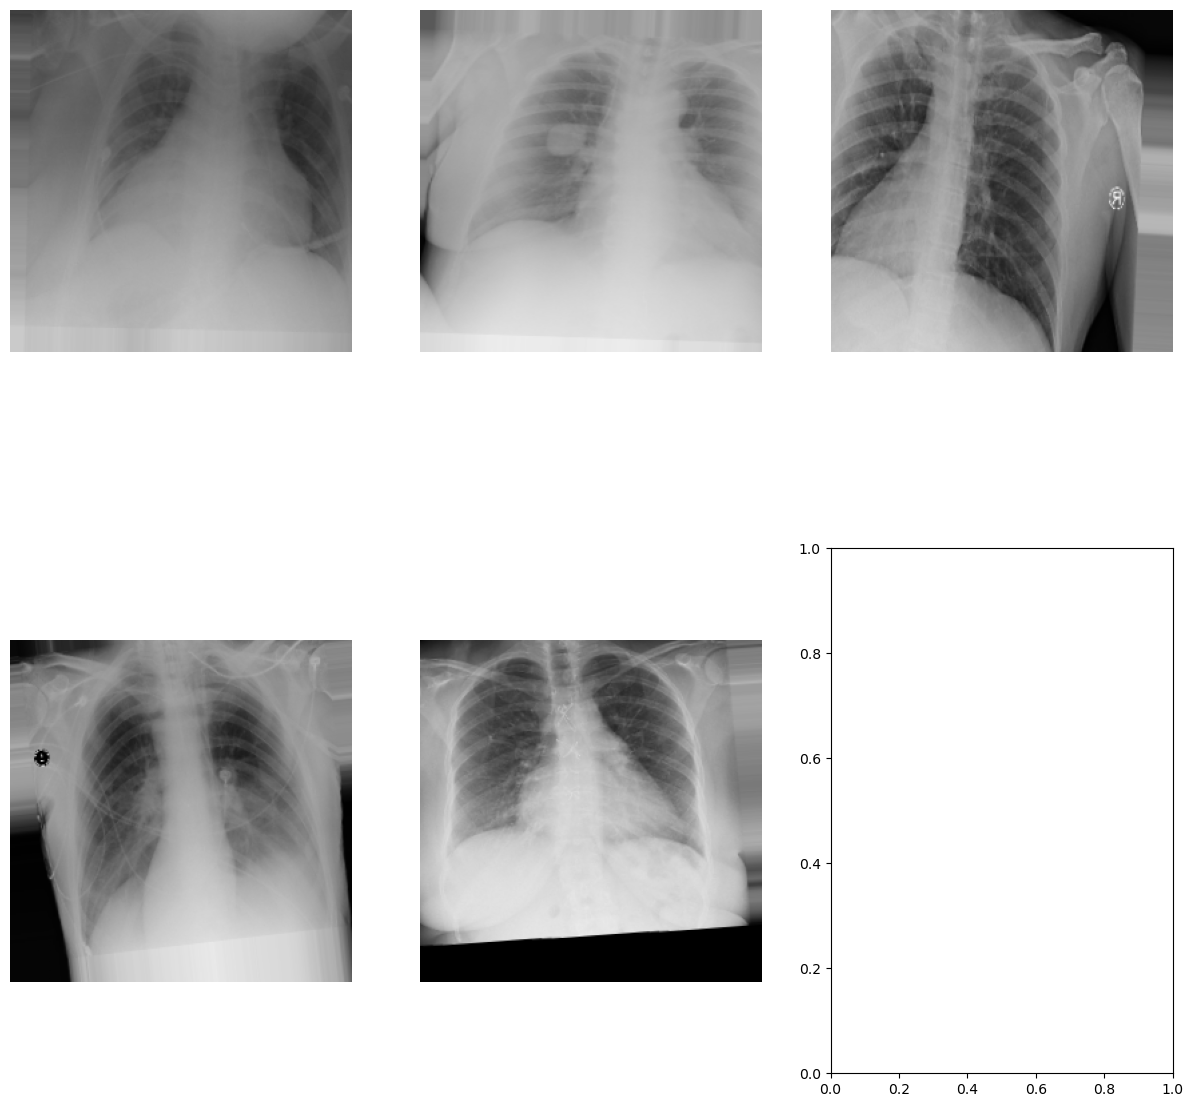

In [71]:
preview_images(train_gen, num_images=5)

**BUILDING AND TRAINING MODEL**

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

weight_path = "{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path,
                             monitor='val_loss',  # Choose the metric to monitor for performance (e.g., val_loss)
                             verbose=1,
                             save_best_only=True,
                             mode='min',  # Choose min or max based on the metric (e.g., min for loss)
                             save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_loss',  # Choose the metric to monitor for early stopping (e.g., val_loss)
                               mode='min',  # Choose min or max based on the metric (e.g., min for loss)
                               patience=10)

callbacks_list = [checkpoint, early_stopping]

In [87]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found. Using CPU.')
else:
    print('GPU device found: {}'.format(device_name))

GPU device found: /device:GPU:0


In [88]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2

def load_pretrained_model():
    # Assign the model to a specific device
    with tf.device('/gpu:0'):
        base_model = MobileNetV2(include_top=False, weights='imagenet')  # Exclude the top classification layers

        # Add custom classification layers
        x = base_model.output
        x = GlobalAveragePooling2D()(x)  # Add global average pooling layer
        x = Dense(512, activation='relu')(x)  # Add additional dense layer
        x = Dropout(0.5)(x)  # Add dropout layer for regularization
        predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

        model = Model(inputs=base_model.input, outputs=predictions)

    return model

model = load_pretrained_model()


In [94]:
import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import accuracy_score, recall_score
import matplotlib.pyplot as plt

def train_model(model, train_dataset, val_dataset, loss_fn, optimizer, num_epochs=5):
    train_loss_results = []
    train_accuracy_results = []
    val_loss_results = []
    val_accuracy_results = []

    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.BinaryAccuracy()

        # Training loop - using batches of dataset
        for x, y in train_dataset:
            # Optimize the model
            with tf.GradientTape() as tape:
                logits = model(x, training=True)
                y = tf.reshape(y, (-1, 1))  # Reshape labels to match logits shape
                loss_value = loss_fn(y, logits)

            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Compute current loss
            epoch_loss_avg(loss_value)
            # Compare predicted label to actual label
            epoch_accuracy(y, logits)

        # End epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

        # Validation loop
        epoch_val_loss_avg = tf.keras.metrics.Mean()
        epoch_val_accuracy = tf.keras.metrics.BinaryAccuracy()
        for x, y in val_dataset:
            val_logits = model(x, training=False)
            y = tf.reshape(y, (-1, 1))  # Reshape labels to match logits shape
            loss_value = loss_fn(y, val_logits)
            epoch_val_loss_avg(loss_value)
            epoch_val_accuracy(y, val_logits)

        val_loss_results.append(epoch_val_loss_avg.result())
        val_accuracy_results.append(epoch_val_accuracy.result())

        print("Epoch {:03d}: Training Loss: {:.3f}, Training Accuracy: {:.3%}".format(epoch,
                                                                                      epoch_loss_avg.result(), 
                                                                                      epoch_accuracy.result()))
        print("             Validation Loss: {:.3f}, Validation Accuracy: {:.3%}".format(epoch_val_loss_avg.result(), 
                                                                                        epoch_val_accuracy.result()))

    return train_loss_results, train_accuracy_results, val_loss_results, val_accuracy_results


In [95]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy



In [96]:
optimizer = Adam(lr=0.001)
criterion = BinaryCrossentropy()

In [ ]:


# Create your model, train_model(model, train_dataset, val_dataset, loss_fn, optimizer, num_epochs=5):

model = train_model(model, train_gen, val_gen, criterion, optimizer, num_epochs=5)